In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd
import configs

# Helper functions

In [2]:
def relu(x, b=0):
    return np.clip(x-b, 0, np.inf)

def normalize(x, ax=1):
    return (x - np.mean(x, axis=ax, keepdims=True))/ (1e-8+np.std(x, axis=ax, keepdims=True))

def pairwise_correlations_centered(x):
    return np.corrcoef(x-np.mean(x, 0))

In [3]:
def get_spiking(acts):
    spikes = poisson(scale*input_acts[i]).rvs()
    return spikes

# poisson(scale*input_acts[i]).rvs()
# # nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs()

# scale = 0.1
# print(np.mean([np.corrcoef(poisson(scale*input_acts[i]).rvs(), poisson(scale*input_acts[i]).rvs())[0, 1] for i in range(100)]))
# print(np.mean([np.corrcoef(poisson(scale*acts[i]).rvs(), poisson(scale*acts[i]).rvs())[0, 1] for i in range(100)]))

# p = 0.1
# print(np.mean([np.corrcoef(nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs(), nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs())[0, 1] for i in range(100)]))
# print(np.mean([np.corrcoef(nbinom(1e-8+acts[i] / (1.0/p - 1.0), p).rvs(), nbinom(1e-8+acts[i] / (1.0/p - 1.0), p).rvs())[0, 1] for i in range(100)]))

In [4]:
def distance(a, b, maximum):
    dist = np.abs(a - b)
    dist = min(dist, np.abs(maximum-dist))
    return dist

# Dynamics function

In [5]:
def run_dynamics(
    W, inputs, divisive_normalization=30.0, dt=0.1,
    n_zero_input=0
    ):
    
    preacts = np.zeros([num_states, N_bar])
    acts = np.zeros([num_states, N_bar])
    acts_over_time = np.zeros([steps+n_zero_input, num_states, N_bar])
    for s in range(steps):
        preacts = preacts*(1-divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar*dt) + dt*np.matmul(acts, W)+dt*inputs
        acts = relu(preacts)
        final_preacts = preacts.copy()
        final_acts = acts.copy()
        acts_over_time[s] = final_acts
    for s in range(n_zero_input):
        preacts = preacts*(1-divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar*dt) + dt*np.matmul(acts, W)
        acts = relu(preacts)
        acts_over_time[steps+s] = acts.copy()
    return final_preacts, final_acts, acts_over_time

# Initialization

In [11]:
# Parameters
N_inp = 2000
N_bar = 2000
num_states = 100
decay_constant = 0.2
steps = 100
b = 10.0 # More positive, more diagonal
divisive_normalization = 30.0
dt = 0.1
rec_strength = 9.0 #8.0
input_strength = 1.0
narrow_search_factor = 0.75
wide_search_factor = 1.25
plasticity_bias = -0.7 
lr = 40.0

cache_states = [20, 30, 70]

In [13]:
# Make place inputs
inputs = np.zeros([num_states, N_inp])
for s in range(num_states):
    peak = int(s / float(num_states) * N_inp)
    for n in range(N_inp):
        dist = distance(n, peak, N_inp)
        inputs[s, n] = np.exp(-(dist/(N_inp*decay_constant)))
inputs = inputs - np.mean(inputs, axis=1, keepdims=True)
inputs = inputs / np.std(inputs, axis=1, keepdims=True)

# Run Task

Now I just cached at location: 20


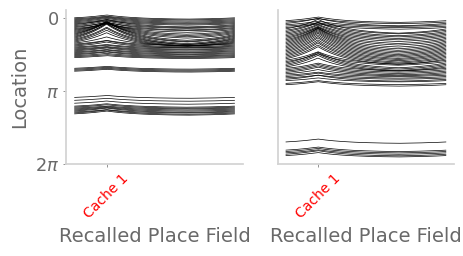

Now I just cached at location: 30


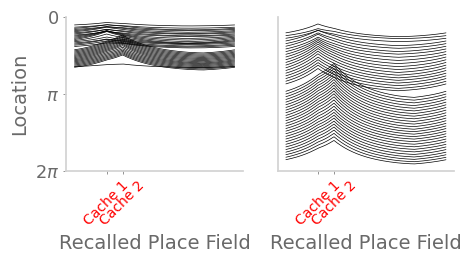

Now I just cached at location: 70


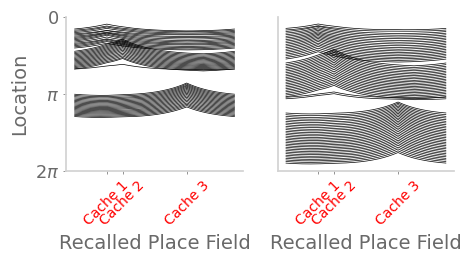

In [50]:
# Initialize weight matrices
W_reconstruct = np.zeros([N_inp, N_bar])
rand_J = np.random.randn(N_bar, N_bar)
W_rec = rec_strength*(rand_J / np.sqrt(N_bar)) - (b / N_bar)
W_fantasy = np.zeros([N_bar])

for c_idx, cache_state in enumerate(cache_states):
    
    fig, ax = plt.subplots(1, 2, figsize=(5, 2))
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, acts_over_time = run_dynamics(W_rec, input_strength*inputs, n_zero_input=20)
    
    W_fantasy += acts[cache_state]
    act = acts[cache_state:cache_state+1]
    preact = preacts[cache_state:cache_state+1]
    delta_W = np.matmul(act.transpose(), preact) + np.matmul(np.ones_like(act.transpose())*plasticity_bias, act)
    W_rec += lr * delta_W / N_bar
    W_reconstruct += inputs[cache_state].reshape(-1, 1) @ acts[cache_state].reshape(1, -1)

    _, acts, _ = run_dynamics(W_rec, input_strength*inputs+narrow_search_factor*W_fantasy) 
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    valid_recall = np.any(reconstruct > reconstruct.mean() + reconstruct.std(), axis=1)
    offset = reconstruct.std()/2
    for idx, validity in enumerate(valid_recall):
        if not validity: continue
        r = reconstruct[idx]
        ax[0].plot(np.arange(r.size), r-offset*idx, color='black', linewidth=0.5)
    
    _, acts, _ = run_dynamics(W_rec, input_strength*inputs+wide_search_factor*W_fantasy) 
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    valid_recall = np.any(reconstruct > reconstruct.mean() + reconstruct.std(), axis=1)
    offset = reconstruct.std()/2
    for idx, validity in enumerate(valid_recall):
        if not validity: continue
        r = reconstruct[idx]
        ax[1].plot(np.arange(r.size), r-offset*idx, color='black', linewidth=0.5)
    
    ax[0].set_ylabel('Location')
    ax[1].set_ylabel('')
    ax[1].set_yticks([])
    ax[0].set_yticks([0, -offset*(num_states//2), -offset*(num_states)], [0, '$\pi$', '$2\pi$'])
    for _ax in ax:
        _ax.set_xlabel('Recalled Place Field')
        xtick_loc = []; xtick_label = [];
        for i, c in enumerate(cache_states[:c_idx+1]):
            xtick_loc.append((c/num_states)*N_bar)
            xtick_label.append(f'Cache {i+1}')
        _ax.set_xticks(xtick_loc, xtick_label, rotation=45, color='red', fontsize=10)
    plt.show()